## Install packages (requires restarting runtime after running cell)

In [1]:
# Install packages.
from IPython.display import clear_output
!pip install captum opencv-python xmltodict
#!pip install -U matplotlib
!pip install quantus
clear_output()
!pip install numpy --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Declare and load classifier

In [2]:
#https://nextjournal.com/gkoehler/pytorch-mnist
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

network = MNISTClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

import numpy as np

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

PATH_DIR = '/content/drive/MyDrive/XAI-Anna-Carlos/'
PATH_PRETRAINED = PATH_DIR + 'mnist-classifier.pth'

import os.path

if os.path.isfile(PATH_PRETRAINED):
  network.load_state_dict(torch.load(PATH_PRETRAINED))
  network.to(device)
else:
  raise Exception('ERROR: Could not find model at ',PATH_PRETRAINED)

Mounted at /content/drive


## Load randomly generated data (takes ~5min.)

In [3]:
FILENAME = PATH_DIR + 'random_generated_auc--.npz'
data = np.load(FILENAME)

In [4]:
# This cell will take a while (<5min)
# I should have named the variables in the NPZ 😅
image = data['arr_0']
label = data['arr_1']
rankings = data['arr_2']
plots = data['arr_3']
inverse_plots = data['arr_4']
hit_plots = data['arr_5']
inverse_hit_plots = data['arr_6']
measures = data['arr_7']
measures_with_inverse = data['arr_8']
measures_auc = data['arr_9']
measures_auc_with_inverse = data['arr_10']

print(measures)


[-0.86637943 -0.39332936 -1.11622971 ... -0.96491077 -0.6600506
 -0.75430563]


## Quick statistics
First, we look at the distribution of the Q scores

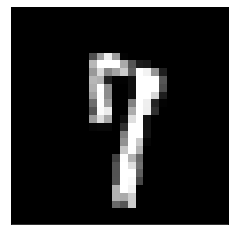

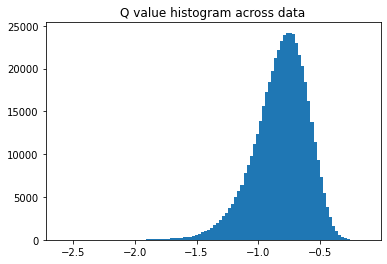

Avg=-0.8218205602873415 Std=0.21673408994939022


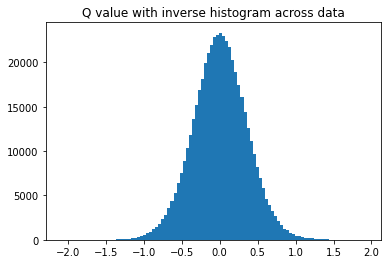

Avg=0.003261873301343424 Std=0.35685235461303366


In [5]:
# Visualization of the image and metrics
import matplotlib.pyplot as plt

index = 22
fig = plt.figure()
plt.tight_layout()
plt.imshow(image[0], cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.show()

plt.hist(measures, bins=100)
plt.title('Q value histogram across data')
plt.show()
avg_q = np.mean(measures)
std_q = np.std(measures)
print(f'Avg={avg_q} Std={std_q}')

plt.hist(measures_with_inverse, bins=100)
plt.title('Q value with inverse histogram across data')
plt.show()
avg_qinv = np.mean(measures_with_inverse)
std_qinv = np.std(measures_with_inverse)
print(f'Avg={avg_qinv} Std={std_qinv}')

Draw the best explanations according to Q and Qinv.

In [ ]:
# Best explanation according to Q
best_ranking = rankings[np.argmax(measures)]
plt.imshow(image[index], cmap='gray', interpolation='none')
plt.imshow(best_ranking.squeeze(), cmap="seismic", alpha=0.5)
plt.title(f'Best random ranking according to Q ({np.max(measures)})')
plt.show()
# Best explanation according to Q with inverse
best_ranking_with_inverse = rankings[np.argmax(measures_with_inverse)]
plt.imshow(image[index], cmap='gray', interpolation='none')
plt.imshow(best_ranking_with_inverse.squeeze(), cmap="seismic", alpha=0.5)
plt.title(f'Best random ranking according to Q with inverse ({np.max(measures_with_inverse)})')
plt.show()

## Compute measures with random baseline

In [ ]:
measures_with_baseline = np.zeros(measures.shape)
for i in range(measures.size):
  j = np.random.randint(measures.size)
  while i==j:
    j = np.random.randint(measures.size)
  measures_with_baseline[i] = measures[i] - measures[j]

In [ ]:
plt.hist(measures_with_baseline, bins=100)
plt.title('Q value with random baseline histogram across data')
plt.show()
avg_qbas = np.mean(measures_with_baseline)
std_qbas = np.std(measures_with_baseline)
print(f'Avg={avg_qbas} Std={std_qbas}')

For these random rankings, Q with baseline looks very similar to Qinv.

Draw the best explanation. It looks just as bad as the others, as expected since these are just random rankings.

In [ ]:
# Best explanation according to Q with baseline
best_ranking_with_baseline = rankings[np.argmax(measures_with_baseline)]
plt.imshow(image[index], cmap='gray', interpolation='none')
plt.imshow(best_ranking_with_baseline.squeeze(), cmap="seismic", alpha=0.5)
plt.title(f'Best random ranking according to Q with baseline({np.max(measures_with_baseline)})')
plt.show()

## Load Quantus to compare with explanations that inspect the model

In [8]:
# Imports general.
import sys
import warnings
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
import captum
from captum.attr import *
import random
import os
import cv2
import PIL
from xml.etree import ElementTree
import xmltodict
import collections

import quantus

import gc
import warnings
# Collect garbage.
gc.collect()
torch.cuda.empty_cache()

# Configs torch (read more on this cuda-related issue here: https://github.com/pytorch/pytorch/issues/45769).
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Notebook settings.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
warnings.filterwarnings("ignore", category=UserWarning)
%load_ext autoreload
%autoreload 2
#clear_output()

Now we generate a few explanations using:


*   Gradient
*   GradientShap
*   InputXGradient
*   IntegratedGradients
*   Saliency

Then check their Q and Qinv and see how it compares with the random generated explanations.



In [11]:
methods = ['Gradient', 'GradientShap', 'InputXGradient', 'IntegratedGradients', 'Saliency']

explanations = {}
for method in methods:
  explanations[method] = quantus.explain(network, torch.from_numpy(image.reshape((1,1,28,28))).to(device), torch.from_numpy(label).to(device), method=method, normalise=True)

NameError: ignored

Let's see how they do. First, load all helper functions.

In [ ]:
def measure_curve(curve):
  return np.mean(curve)

def measure_curve_with_inverse(curve, inverse_curve):
  return np.mean(curve-inverse_curve)


####################################
# Additional definitions of Q.
####################################

def measure_auc(values: np.array, dx: int = 1):
    return np.trapz(np.array(curve), dx=dx)


def get_masked_images(original_image, alternative_image, ranking_image, selection_levels):
  '''
  Generates as many masked images as selection levels are provided
  Inputs are torch tensors already on device
  '''
  # Reshape selection_levels to be able to broadcast the selection levels and get
  # as many masks as selection levels are provided
  new_shape = (selection_levels.shape[0], 1, 1, 1) # Same shape but with a trailing 1
  selection_levels = torch.reshape(selection_levels, new_shape)
  # Compute all masks in batch
  masks = torch.le(ranking_image,selection_levels)
  # Compute masked images from masks and original and alternative images
  images_masked = (original_image*masks) + (alternative_image*torch.logical_not(masks))
  return images_masked

def get_random_ranking_image(dimensions):
  num_elems = 1
  for d in dimensions:
    num_elems *= d
  image = np.random.permutation(num_elems).reshape(dimensions)/num_elems
  return torch.from_numpy(image)

def get_class_logits_for_masked_images(original_image, alternative_image, ranking_image, selection_levels, model, class_num):
  with torch.no_grad():
    # Send everything to device and work there
    image = original_image.to(device)
    alternative = alternative_image.to(device)
    ranking = ranking_image.to(device)
    levels = selection_levels.to(device)
    images = get_masked_images(image, alternative, ranking, levels)
    logits = model(images).to('cpu').numpy()
  return logits[:,class_num],np.equal(np.argmax(logits, axis=1),class_num)

def save_explanation_exploratory_plot(image, curve, is_hit, output_label, filename='unnamed'):
  # Plot and save the figures
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
  axes[0].imshow(image[0], cmap='gray', interpolation='none')
  axes[0].title.set_text(output_label)
  axes[0].axis("off")
  for i in range(1, len(curve)):
    axes[1].plot([i-1,i],curve[i-1:i+1], lw=5 if is_hit[i] else 1, color='b')
  fig.savefig(f'{filename}.png')
  plt.show()

def get_explanation_exploratory_curve(image, ranking_image, num_samples, output_label, model):
  alternative = torch.from_numpy(np.full(image.shape,  0, dtype=np.float32)) #ZEROED-OUT

  # Selection levels
  selection_levels = torch.from_numpy(np.linspace(0, 1, num_samples))

  # Increasing order
  class_logit,is_hit = get_class_logits_for_masked_images(image, alternative, ranking_image, selection_levels, model, output_label)

  # Compute the numerical value for the measure
  #measure = measure_curves(class_logit)

  return class_logit,is_hit

def attributions_to_ranking_image(attributions, reverse=False):
  ranked_attributions = []
  for i in range(attributions.shape[2]):
    for j in range(attributions.shape[3]):
      ranked_attributions.append([attributions[0,0,i,j],i,j])
  ranked_attributions.sort(reverse=reverse)
  ranked_attributions = np.array(ranked_attributions)
  ranking_image = np.zeros(attributions.shape)
  num_attributes = ranked_attributions.shape[0]
  for i in range(num_attributes):
    x = int(ranked_attributions[i][1])
    y = int(ranked_attributions[i][2])
    ranking_image[0,0,x,y] = i/num_attributes
  return ranking_image

# TEST
#attributions_to_ranking_image(np.array([[[1,2],[3,4]]]))

## Actual measurements of the explanations

Reminder:
Q: Avg=-1.1647272397570325 Std=0.34172787728266757
Qinv: Avg=0.0016681147369008635 Std=0.5990668181542208
Qbas: Avg=-0.0004697014615738853 Std=0.48326151344563056
---- Method:Gradient
Actual Z-score:-2.5764
	(Qinv Z-score wrt Qinv distribution:-3.2310)
	Estimations:
		Qinv:-1.9339
		Qbas:-1.2820


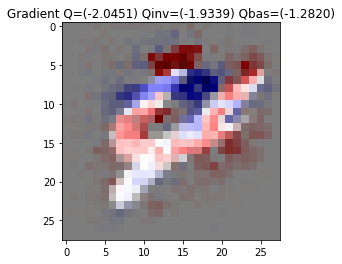

---- Method:GradientShap
Actual Z-score:-3.3534
	(Qinv Z-score wrt Qinv distribution:-3.6818)
	Estimations:
		Qinv:-2.2040
		Qbas:-1.3145


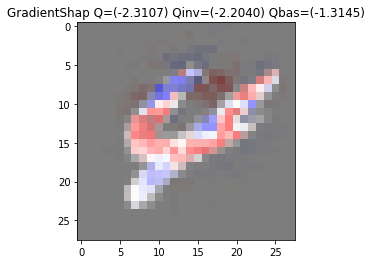

---- Method:InputXGradient
Actual Z-score:-3.1969
	(Qinv Z-score wrt Qinv distribution:-3.5922)
	Estimations:
		Qinv:-2.1503
		Qbas:-1.0951


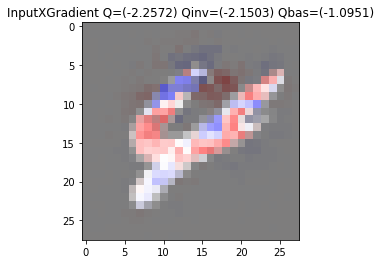

---- Method:IntegratedGradients
Actual Z-score:-3.3201
	(Qinv Z-score wrt Qinv distribution:-3.6628)
	Estimations:
		Qinv:-2.1926
		Qbas:-1.4116


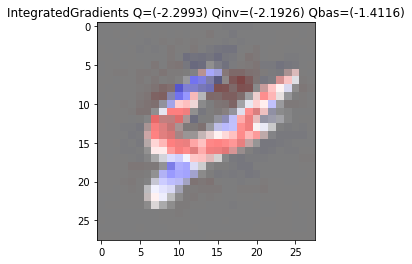

---- Method:Saliency
Actual Z-score:1.6457
	(Qinv Z-score wrt Qinv distribution:-0.1470)
	Estimations:
		Qinv:-0.0864
		Qbas:-0.0953


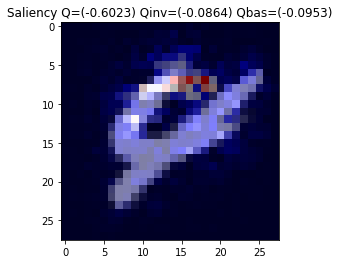

In [ ]:
# TODO - REMOVE - Should be read from file
num_samples = plots.shape[1]

print("Reminder:")
print(f'Q: Avg={avg_q} Std={std_q}')
print(f'Qinv: Avg={avg_qinv} Std={std_qinv}')
print(f'Qbas: Avg={avg_qbas} Std={std_qbas}')
print(f'Qbas: Avg={avg_qauc} Std={std_qauc}')

zscores = np.zeros(len(methods))
qbas_estimations = np.zeros(len(methods))
qinv_estimations = np.zeros(len(methods))
qauc_estimations = np.zeros(len(methods))

for i,method in enumerate(methods):
  curve,is_hit = get_explanation_exploratory_curve(torch.from_numpy(image), torch.from_numpy(explanations[method]), num_samples, label, network)
  q = measure_curve(curve)
  inverse_ranking_image = attributions_to_ranking_image(explanations[method], reverse=True)
  inverse_curve,inverse_is_hit = get_explanation_exploratory_curve(torch.from_numpy(image), torch.from_numpy(inverse_ranking_image), num_samples, label, network)
  qinv = measure_curve_with_inverse(curve, inverse_curve)
  random_curve,random_is_hit = get_explanation_exploratory_curve(torch.from_numpy(image), get_random_ranking_image(inverse_ranking_image.shape), num_samples, label, network)
  qbas = q - measure_curve(random_curve)
  qauc = measure_auc(curve, inverse_curve)
  
  print(f'---- Method:{method}')
  zscores[i] = (q-avg_q)/std_q
  qbas_estimations[i] = qbas
  qinv_estimations[i] = qinv
  qauc_estimations[i] = qauc
  print(f'Actual Z-score:{zscores[i]:.4f}')
  print(f'\t(Qinv Z-score wrt Qinv distribution:{(qinv-avg_qinv)/std_qinv:.4f})')
  print(f'\t(Qinv Z-score wrt Qinv distribution:{(qauc-avg_qauc)/std_qauc:.4f})')
  print(f'\tEstimations:')
  print(f'\t\tQinv:{qinv:.4f}')
  print(f'\t\tQbas:{qbas:.4f}')
  print(f'\t\tQauc:{qauc:.4f}')
  plt.imshow(image[0], cmap='gray', interpolation='none')
  plt.imshow(explanations[method][0][0], cmap="seismic", alpha=0.5)
  plt.title(f'{method} Q=({q:.4f}) Qinv=({qinv:.4f}) Qbas=({qbas:.4f})')
  plt.show()
  

Let's plot estimators vs z-score.

The idea here is that the z-score wouldn't be available when evaluating how faithful an explanation is (you would need to compute the mean and std of a population of possible explanations to compute the z-score), so you need a quick computation that estimates it. People usually do `Qbas`, which is the Q score of the ranking to evaluate minus the Q score of a random ranking. We propose `Qinv` which is the Q score of the ranking to evaluate minus the Q score of the inverse of said ranking (that is, the ranking taken from end to beginning). We wnat to check which of the two is a better estimator.

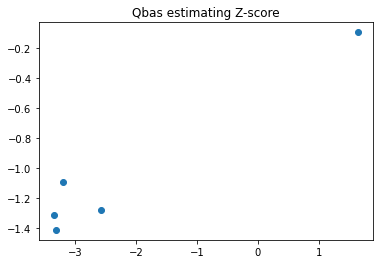

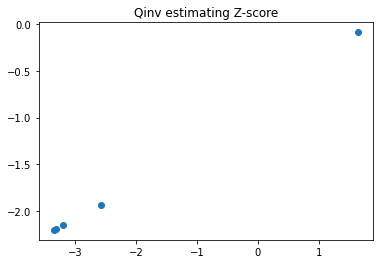

In [ ]:
plt.scatter(zscores, qbas_estimations)
plt.title('Qbas estimating Z-score')
plt.show()

plt.scatter(zscores, qinv_estimations)
plt.title('Qinv estimating Z-score')
plt.show()

It seems Qinv does a better job at estimating the Z-score. Let's check with a larger sample size.

In [ ]:
# Do a 80/20 train-test split
random_indices = np.random.permutation(rankings.shape[0])
num_training = int(random_indices.size*0.8)
train_indices = random_indices[:num_training]
test_indices = random_indices[num_training:]

# Load rankings
rankings_train = rankings[train_indices]
rankings_test = rankings[test_indices]
# Load precomputed data for those rankings
measures_train = measures[train_indices]
measures_test = measures[test_indices]
measures_with_inverse_test = measures_with_inverse[test_indices]

# Compute the train distribution parameters that will allow the ground-truth z-score calculation
avg_q_train = np.mean(measures_train)
std_q_train = np.std(measures_train)

# Now we need to compute a bunch of random curve q-scores to compute qbas. Also, we compute the z-scores.
from tqdm import tqdm
qbas_test = np.zeros(measures_test.size)
zscores = np.zeros(measures_test.size)
for i in tqdm(range(measures_test.size)):
  random_curve,random_is_hit = get_explanation_exploratory_curve(torch.from_numpy(image), get_random_ranking_image(image.shape), num_samples, label, network)
  qbas_test[i] = measures_test[i] - measure_curve(random_curve)
  zscores[i] = (measures_test[i]-avg_q_train)/std_q_train

100%|██████████| 100000/100000 [06:10<00:00, 270.25it/s]


Pearson correlation z-score vs qbas:0.7739576093380689


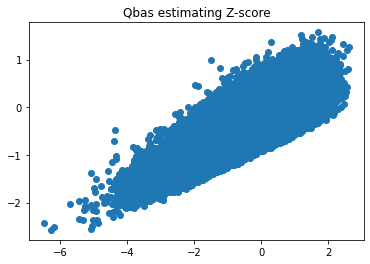

Pearson correlation z-score vs qinv:0.8773855616478032


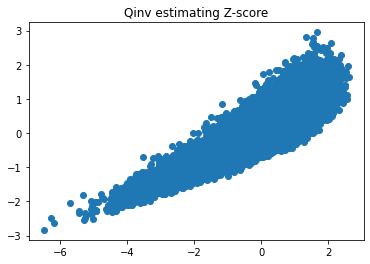

In [ ]:
# Now plot the estimations
print(f'Pearson correlation z-score vs qbas:{np.corrcoef(zscores,qbas_test)[0][1]}')
plt.scatter(zscores, qbas_test)
plt.title('Qbas estimating Z-score')
plt.show()

print(f'Pearson correlation z-score vs qinv:{np.corrcoef(zscores,measures_with_inverse_test)[0][1]}')
plt.scatter(zscores, measures_with_inverse_test)
plt.title('Qinv estimating Z-score')
plt.show()

For random rankings, the difference does not look too large.

Let's try with rankings that are better than average (generated with the genetic algorithm).

In [ ]:
'''del(rankings)
del(plots)
del(inverse_plots)
del(hit_plots)
del(inverse_hit_plots)
del(measures)
del(measures_with_inverse)
del(rankings_train)
del(rankings_test)
del(measures_train)
del(measures_test)
del(measures_with_inverse_test)
'''
FILENAME = PATH_DIR + 'genetic_generated.npz'
data_g = np.load(FILENAME)

image_g = data_g['arr_0']
label_g = data_g['arr_1']
rankings_g = data_g['arr_2']
plots_g = data_g['arr_3']
inverse_plots_g = data_g['arr_4']
hit_plots_g = data_g['arr_5']
inverse_hit_plots_g = data_g['arr_6']
measures_g = data_g['arr_7']
measures_with_inverse_g = data_g['arr_8']

In [ ]:
# Just in case the data doesn't correspond to the same image
assert(np.equal(image,image_g).all())
assert(label==label_g)

In [ ]:
qbas_gen = np.zeros(measures_g.size)
zscores_gen = np.zeros(measures_g.size)
for i in tqdm(range(measures_g.size)):
  random_curve,random_is_hit = get_explanation_exploratory_curve(torch.from_numpy(image), get_random_ranking_image(image.shape), num_samples, label, network)
  qbas_gen[i] = measures_g[i] - measure_curve(random_curve)
  zscores_gen[i] = (measures_g[i]-avg_q_train)/std_q_train

100%|██████████| 500000/500000 [29:54<00:00, 278.69it/s]


Pearson correlation z-score vs qbas:0.7959360294434469


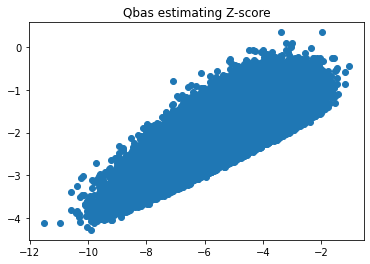

Pearson correlation z-score vs qinv:0.9549560678404869


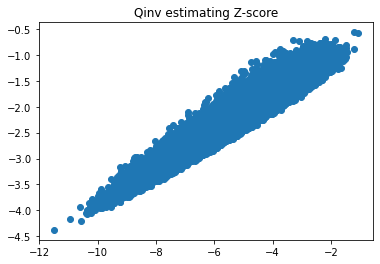

In [ ]:
# Now plot the estimations
print(f'Pearson correlation z-score vs qbas:{np.corrcoef(zscores_gen,qbas_gen)[0][1]}')
plt.scatter(zscores_gen, qbas_gen)
plt.title('Qbas estimating Z-score')
plt.show()

print(f'Pearson correlation z-score vs qinv:{np.corrcoef(zscores_gen,measures_with_inverse_g)[0][1]}')
plt.scatter(zscores_gen, measures_with_inverse_g)
plt.title('Qinv estimating Z-score')
plt.show()

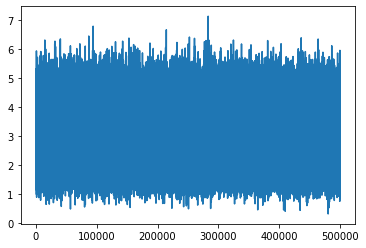

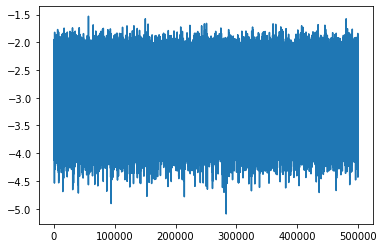

In [ ]:
errors = np.abs(zscores_gen-measures_with_inverse_g)
plt.plot(errors)
plt.show()

plt.plot(measures_g)
plt.show()

In [ ]:
print(np.mean(measures_g[:100]))
print(np.mean(measures_g[200000:200100]))
print(np.mean(measures_g))

-1.1775443725052883
-1.2093183077070824
-1.1647272397570325
